**Overtone Extraction**

This script extracts overtone magnitudes and phases with previously extracted pitch and pitch increment trajectories.  
Overtones are extracted by per-frame division of source x by complex sinusoidal taking pitch and pitch derivative into account.

In [1]:
%load_ext autoreload
%autoreload 2

#hsvs includes
from hsvs.tools import dataset, framed_audio, magnitude, extract_overtones
import hsvs

# 3rd party dependencies
from matplotlib import pyplot as plt
import numpy as np
import soundfile
from tqdm import tqdm

In [2]:
vowel  = 'i'  # [a,e,i,o,u]
singer = 'f5' # [f1 - f9, m1-m11]

num_overtones_extracted = 60 # overtones 
num_overtones_stored    = 40

# wav and json file path 
singer_vowel_dir = singer + '_' + vowel
source_file = dataset.get_sample('scales', 'slow_forte', vowel, singer)[0]
data_path   = os.path.abspath(os.path.join(os.path.dirname(hsvs.__file__), os.pardir, 'data'))
json_file   = os.path.join(data_path, 'results', singer_vowel_dir, 'audio.json' )
out_file_harm = os.path.join(data_path, 'results', singer_vowel_dir, 'audio', 'harmonic.wav' )
out_file_org  = os.path.join(data_path, 'results', singer_vowel_dir, 'audio', 'original.wav' )

In [3]:
# loading the stored audio json file explicitely with the audio wave file to prevent portability issues.
audio = framed_audio.FramedAudio.from_json(json_file, wav_replacement=source_file)

#run overtone extraction, pitch and pitch-inc are assumed to be stored as trajectories in the audio object
overtones = extract_overtones.extract_overtones_from_audio(audio, num_overtones = num_overtones_extracted)

# convert to decibel and normalize
overtonesDB  = 20. * np.log10(np.abs(overtones))
overtonesDB -= np.max(overtonesDB)

# store in json
audio.store_trajectory('overtones', overtonesDB[:, 0:num_overtones_stored])

100%|██████████| 7132/7132 [01:22<00:00, 86.93it/s]


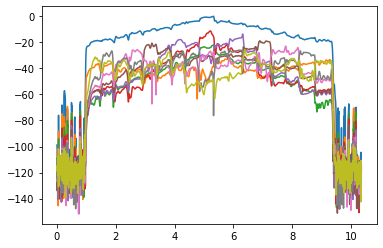

In [4]:
# plot first 10 overtone trajectories
plots = plt.plot(audio.get_time(), overtonesDB[:,0:9])

**Reconstruction**

The following cell reconstructs the audio from the pitch and pitch increment trajectories as well as the overtone data.  
Reconstruction is performed per-frame with an overlapp add method and hanning windowing

In [5]:
# synthesize audio
pitch     = audio.get_trajectory('pitch')
pitch_inc = audio.get_trajectory('pitch-inc')

x = np.zeros(audio.get_num_frames() * audio.hop_size + audio.block_size)
window = 2 * np.hanning(audio.block_size)
for i in tqdm(range(audio.get_num_frames())):
    frame = extract_overtones.synthesize_overtones(overtones[i,:], pitch[i], pitch_inc[i], audio.fs, audio.block_size)

    x0 =  i * audio.hop_size
    x1 = x0 + audio.block_size

    overlap_factor = 2 * audio.hop_size / audio.block_size 
    x[x0:x1] += frame * window * overlap_factor



100%|██████████| 7132/7132 [00:21<00:00, 338.23it/s]


In [6]:
#store results
audio.save_json(json_file=json_file)

# create dirs if they don't exist yet
audio_path = os.path.dirname(out_file_harm)
if not os.path.exists(audio_path):
            os.makedirs(audio_path)
            
org = audio.get_raw()

# store synthesized and original audio 
soundfile.write(out_file_harm, x * (0.5/max(abs(x))), audio.fs)
soundfile.write(out_file_org, org * (0.5/max(abs(org))), audio.fs)
